# smallBox and bigBox 合併

In [1]:
import sys
sys.path.append("..")

import pandas as pd
from models import Yolov4
from tensorflow import keras
from config import yolo_config
from utils import DataGenerator, read_annotation_lines

import cv2 as cv
import numpy as np
from glob import glob
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay

import math
# import torch
import xml.etree.ElementTree as ET
import os

# 使用第二張 GPU 卡
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
def get_iou(bbox_ai, bbox_gt):
    iou_x = max(bbox_ai[0], bbox_gt[0]) # x
    iou_y = max(bbox_ai[1], bbox_gt[1]) # y
    iou_w = min(bbox_ai[2]+bbox_ai[0], bbox_gt[2]+bbox_gt[0]) - iou_x # w
    iou_w = max(iou_w, 0)
    # print(f'{iou_w=}')
    iou_h = min(bbox_ai[3]+bbox_ai[1], bbox_gt[3]+bbox_gt[1]) - iou_y # h
    iou_h = max(iou_h, 0)
    # print(f'{iou_h=}')

    iou_area = iou_w * iou_h
    # print(f'{iou_area=}')
    all_area = bbox_ai[2]*bbox_ai[3] + bbox_gt[2]*bbox_gt[3] - iou_area
    # print(f'{all_area=}')

    if all_area == 0:  # 有可能雙方皆沒有重疊，或是一開始就沒有label
        return 0
    return max(iou_area/all_area, 0)

In [3]:
def calculate_ciou(box_1, box_2):
    """
    calculate ciou
    :param box_1: (x0, y0, x1, y1)
    :param box_2: (x0, y0, x1, y1)
    :return: value of ciou
    """
    # perfect
    if box_1==box_2:  
        return 1.0

    # calculate area of each box
    width_1 = box_1[2] - box_1[0]
    height_1 = box_1[3] - box_1[1]
    area_1 = width_1 * height_1

    width_2 = box_2[2] - box_2[0]
    height_2 = box_2[3] - box_2[1]
    area_2 = width_2 * height_2

    # calculate center point of each box
    center_x1 = (box_1[2] - box_1[0]) / 2
    center_y1 = (box_1[3] - box_1[1]) / 2
    center_x2 = (box_2[2] - box_2[0]) / 2
    center_y2 = (box_2[3] - box_2[1]) / 2

    # calculate square of center point distance
    p2 = (center_x2 - center_x1) ** 2 + (center_y2 - center_y1) ** 2

    # calculate square of the diagonal length
    width_c = max(box_1[2], box_2[2]) - min(box_1[0], box_2[0])
    height_c = max(box_1[3], box_2[3]) - min(box_1[1], box_2[1])
    c2 = width_c ** 2 + height_c ** 2

    # find the edge of intersect box
    left = max(box_1[0], box_2[0])
    top = max(box_1[1], box_2[1])
    bottom = min(box_1[3], box_2[3])
    right = min(box_1[2], box_2[2])

    # calculate the intersect area
    area_intersection = (right - left) * (bottom - top)

    # calculate the union area
    area_union = area_1 + area_2 - area_intersection

    # calculate iou
    iou = float(area_intersection) / area_union

    # calculate v
    arctan = math.atan(float(width_2) / height_2) - math.atan(float(width_1) / height_1)
    v = (4.0 / math.pi ** 2) * (arctan ** 2)

    # calculate alpha
    alpha = float(v) / (1 - iou + v)

    # calculate ciou(iou - p2 / c2 - alpha * v)
    ciou = iou - float(p2) / c2 - alpha * v

    return ciou

In [4]:
def plt_precision_recall_curve(y_true, y_scores):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    average_precision             = average_precision_score(y_true, y_scores)
    # 用套件畫
    # disp = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=average_precision)
    # disp.plot()
    # plt.ylim([0.0, 1.05])
    # plt.xlim([0.0, 1.0])
    # plt.show()

    # 自己畫
    plt.plot(recall, precision, 'b-o')     
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title('precision_recall_curve')
    plt.legend(['AP={}'.format(round(average_precision))])
    plt.show()

    print('precision = ', precision)
    print('recall = ', recall)
    print('thresholds = ',thresholds)
    print('AP={:.2f}'.format(average_precision))

In [5]:
def pltText(x_, y_, clas):
    for x, y in zip(x_, y_):
        if clas == 'big':
            plt.text(x,y,str(round(y,2)),ha='left',va='top',fontsize=10, color='r',rotation=45,)
        elif clas == 'union':
            plt.text(x,y,str(round(y,2)),ha='left',va='bottom',fontsize=10, color='b',rotation=45,)

# 載入模型

In [6]:
# yolo_config['score_threshold']=0.7
# print(yolo_config)

In [7]:
import warnings
warnings.filterwarnings('ignore')
class_name_path = '../class_names/classes.txt'

##bigBox 
model_Bigbox = Yolov4(weight_path=None, class_name_path=class_name_path, config=yolo_config)
model_Bigbox.load_weights(path="../model/20220628_big.weights")

##smallBox
model_Smallbox = Yolov4(weight_path=None, class_name_path=class_name_path, config=yolo_config)
model_Smallbox.load_weights(path="../model/20220610.weights")

nms iou: 0.2 score: 0.5
nms iou: 0.2 score: 0.5


# 影片

In [8]:
# test_dir = 'test_i'
# test_img_paths = glob("../test_img/{}/*.png".format(test_dir))
# test_img_paths[0].split('\\')[1]


# '''
# output_img: image array
# detections: DataFram of box(x1,y1,x2,y2)
# '''
# pred_box_num = 0  # 有預測框的圖像數量
# for test_img_path in tqdm(test_img_paths):
#     test_img_no = test_img_path.split('\\')[1]
#     output_img, detections = model.predict(img_path=test_img_path, 
#                          random_color=False, # 框顏色
#                          plot_img=False, # 顯示出框選圖片
#                          show_text=True, # 框上面加上類別文字
#                          box_num=1,      # 顯示框的數量
#                          return_output=True)
#     if len(detections) == 1:
#         pred_box_num += 1
#     plt.imsave('../result_img/{}/test_{}'.format('test_i_big_box',test_img_no),output_img)

# print('有預測框的圖像數量=', pred_box_num)

# 每一個test 真實box數值

In [9]:
PATH = '../test_img/X_test_bigbox_56/'

true_bbox = {}

for test_img_path in glob(os.path.join(PATH, '*.png')):
    XML_PATH = test_img_path.split('.p')[0] + '.xml'
    test_img_name = test_img_path.split('\\')[1]

    try:
        in_file = open(XML_PATH)

        # Parse .xml file
        tree = ET.parse(in_file)
        root = tree.getroot()

        for obj in root.iter('object'):

            xmlbox = obj.find('bndbox')
            b = (int(xmlbox.find('xmin').text), 
                int(xmlbox.find('ymin').text), 
                int(xmlbox.find('xmax').text), 
                int(xmlbox.find('ymax').text))
            true_bbox[test_img_name] = b

    except:
        true_bbox[test_img_name] = 'nan'
        print('因為沒有label 所以"nan"')
        

# 每一個預測的box數值

In [10]:
pred_Big_bbox = {}
for test_img_path in glob(os.path.join(PATH, '*.png')):
    test_img_name = test_img_path.split('\\')[1]
    output_img, detections = model_Bigbox.predict(img_path=test_img_path,              # model_Bigbox
                                                  random_color=False,  # 框顏色
                                                  plot_img=False,      # 顯示出框選圖片
                                                  show_text=True,      # 框上面加上類別文字
                                                  box_num=1,           # 顯示框的數量
                                                  return_output=True)

    try:
        pred_Big_bbox[test_img_name] = tuple(detections[['x1','y1','x2','y2']].to_numpy()[0])
    except:
        print('沒有預測出來有box(label)')
        pred_Big_bbox[test_img_name] = 'nan' 

# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 0
沒有預測出來有box(label)
# of bboxes: 1
# of bboxes: 1
# of bboxes: 0
沒有預測出來有box(label)
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 0
沒有預測出來有box(label)
# of bboxes: 1
# of bboxes: 1
# of bboxes: 2
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 2
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 2
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1


In [11]:
pred_Small_bbox = {}
for test_img_path in glob(os.path.join(PATH, '*.png')):
    test_img_name = test_img_path.split('\\')[1]
    output_img, detections = model_Smallbox.predict(img_path=test_img_path,        # model_Smallbox
                                               random_color=False,  # 框顏色
                                               plot_img=False,      # 顯示出框選圖片
                                               show_text=True,      # 框上面加上類別文字
                                               box_num=1,           # 顯示框的數量
                                               return_output=True)

    try:
        pred_Small_bbox[test_img_name] = tuple(detections[['x1','y1','x2','y2']].to_numpy()[0])
    except:
        print('沒有預測出來有box(label)')
        pred_Small_bbox[test_img_name] = 'nan' 

# of bboxes: 1
# of bboxes: 0
沒有預測出來有box(label)
# of bboxes: 0
沒有預測出來有box(label)
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 0
沒有預測出來有box(label)
# of bboxes: 1
# of bboxes: 0
沒有預測出來有box(label)
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 0
沒有預測出來有box(label)
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 0
沒有預測出來有box(label)
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 0
沒有預測出來有box(label)
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 2
# of bboxes: 0
沒有預測出來有box(label)
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1
# of bboxes: 1


# Union 大框&小框
1. 兩個框重疊，以大框為主
2. 兩個框部分重疊，放大範圍
3. 兩個框無重疊，以大框為主

In [45]:
from matplotlib import style


def draw_rectangle_And_Union(img, pred_Big_bbox, pred_Small_bbox):
    Bigbox   = pred_Big_bbox
    Smallbox = pred_Small_bbox
    
    # 如果大(小)框沒有預測出來，就採用小(大)框
    if Bigbox=='nan' and Smallbox!='nan':
        cv.rectangle(img, (Smallbox[0], Smallbox[1]), (Smallbox[2], Smallbox[3]), (0, 0, 255), 2)  # small
        return img,Smallbox
    elif Smallbox=='nan' and Bigbox!='nan':
        cv.rectangle(img, (Bigbox[0], Bigbox[1]), (Bigbox[2], Bigbox[3]), (255, 0, 0), 2)          # big
        return img,Bigbox
    # 如果大、小框都沒有預測出來，就回傳'nan'
    elif Smallbox=='nan' and Bigbox=='nan':
        return img, 'nan'
        
    else:
        ## 畫圖
        # cv.rectangle(img, (Bigbox[0], Bigbox[1]), (Bigbox[2], Bigbox[3]), (255, 0, 0), 2)          # big
        # cv.rectangle(img, (Smallbox[0], Smallbox[1]), (Smallbox[2], Smallbox[3]), (0, 0, 255), 2)  # small
        # plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        # plt.show()

        ## union邏輯
        ciou = get_iou(Bigbox,Smallbox)
        # 1. 兩個框重疊，以大框為主、 2. 兩個框部分重疊，放大範圍
        if ciou>0:
            a = min(Bigbox[0],Smallbox[0])
            b = min(Bigbox[1],Smallbox[1])
            c = max(Bigbox[2],Smallbox[2])
            d = max(Bigbox[3],Smallbox[3])
            Unionbox = (a,b,c,d)
            cv.rectangle(img, (a, b), (c, d), (0, 0, 0), 2)
            return img, Unionbox
        # 3. 兩個框無重疊，以大框為主
        else:
            cv.rectangle(img, (Bigbox[0], Bigbox[1]), (Bigbox[2], Bigbox[3]), (0, 0, 0), 2)
            return img, Bigbox

In [46]:
Union_box={}
for img_name in pred_Big_bbox:
    path = PATH + img_name
    img_array = cv.imread(path)
    img, Unionbox = draw_rectangle_And_Union(img_array, pred_Big_bbox[img_name], pred_Small_bbox[img_name])

    # print("img_name= ",img_name,", Unionbox= ", Unionbox)
    Union_box[img_name] = Unionbox
    # plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    # plt.show()

In [41]:
len(pred_Big_bbox)

56

In [42]:
len(pred_Small_bbox)

56

In [43]:
len(true_bbox)

56

# 計算iou
參數:

iou_threshold = 0.7    "iou大於0.7才是有框選到"

In [47]:
def valid(TP, FN, FP, TN):
    precision = TP/(TP+FP)
    recall    = TP/(TP+FN)
    f1        = 2*precision*recall/(precision+recall)

    print('precision={:.2f}, recall={:.2f}, f1={:.2f}'.format(precision, recall, f1))
    print(TP,"|",FN,"\n"
         ,FP,"|",TN)

    return precision, recall, f1

# Union_Box結果

In [48]:
ciou_thresholds = np.arange(0.1, 0.9, 0.1)
test_img_names = true_bbox.keys()
precisions, recalls, f1s = [], [], []
for iou_threshold in ciou_thresholds:
    TP,FP,FN,TN = 0,0,0,0
    y_true   = []  # 0:無壺腹乳頭 1:有壺腹乳頭
    y_scores = []  # ciou分數
    for test_img_name in test_img_names:
        if true_bbox[test_img_name] != 'nan' and Union_box[test_img_name] != 'nan':
            ciou = calculate_ciou(true_bbox[test_img_name], Union_box[test_img_name])  # 找出真實box和預測box的iou
            
            if ciou>=iou_threshold:   # 如果>=iou，才是有預測到，TP會增加
                y_true.append(1)
                y_scores.append(ciou)
                TP += 1
            else:
                y_true.append(1)
                y_scores.append(0)
                FN += 1               # 如果<iou，FN也會增加
        elif true_bbox[test_img_name] != 'nan' and Union_box[test_img_name] == 'nan':
            y_true.append(1)
            y_scores.append(0)
            FN += 1
        elif true_bbox[test_img_name] == 'nan' and Union_box[test_img_name] != 'nan':
            y_true.append(0)
            y_scores.append(1)
            FP += 1
        else:
            y_true.append(0)
            y_scores.append(0)
            TN += 1

    
    # plt_precision_recall_curve(y_true, y_scores)
    precision, recall, f1 = valid(TP, FN, FP, TN)
    # print('ciou_threshold={}'.format(iou_threshold))
    # print("------------------------------------------------------------------------------------")
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

precision=1.00, recall=0.96, f1=0.98
54 | 2 
 0 | 0
precision=1.00, recall=0.96, f1=0.98
54 | 2 
 0 | 0
precision=1.00, recall=0.96, f1=0.98
54 | 2 
 0 | 0
precision=1.00, recall=0.96, f1=0.98
54 | 2 
 0 | 0
precision=1.00, recall=0.89, f1=0.94
50 | 6 
 0 | 0
precision=1.00, recall=0.80, f1=0.89
45 | 11 
 0 | 0
precision=1.00, recall=0.50, f1=0.67
28 | 28 
 0 | 0
precision=1.00, recall=0.21, f1=0.35
12 | 44 
 0 | 0


# Big_Box結果

In [26]:
ciou_thresholds = np.arange(0.1, 0.9, 0.1)
test_img_names = true_bbox.keys()
precisions, recalls, f1s = [], [], []
for iou_threshold in ciou_thresholds:
    TP,FP,FN,TN = 0,0,0,0
    y_true   = []  # 0:無壺腹乳頭 1:有壺腹乳頭
    y_scores = []  # ciou分數
    for test_img_name in test_img_names:
        if true_bbox[test_img_name] != 'nan' and pred_Big_bbox[test_img_name] != 'nan':
            ciou = calculate_ciou(true_bbox[test_img_name], pred_Big_bbox[test_img_name])  # 找出真實box和預測box的iou
            
            if ciou>=iou_threshold:   # 如果>=iou，才是有預測到，TP會增加
                y_true.append(1)
                y_scores.append(ciou)
                TP += 1
            else:
                y_true.append(1)
                y_scores.append(0)
                FN += 1               # 如果<iou，FN也會增加
        elif true_bbox[test_img_name] != 'nan' and pred_Big_bbox[test_img_name] == 'nan':
            y_true.append(1)
            y_scores.append(0)
            FN += 1
        elif true_bbox[test_img_name] == 'nan' and pred_Big_bbox[test_img_name] != 'nan':
            y_true.append(0)
            y_scores.append(1)
            FP += 1
        else:
            y_true.append(0)
            y_scores.append(0)
            TN += 1

    
    # plt_precision_recall_curve(y_true, y_scores)
    precision, recall, f1 = valid(TP, FN, FP, TN)
    # print('ciou_threshold={}'.format(iou_threshold))
    # print("------------------------------------------------------------------------------------")
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

precision=1.00, recall=0.95, f1=0.97
53 | 3 
 0 | 0
precision=1.00, recall=0.95, f1=0.97
53 | 3 
 0 | 0
precision=1.00, recall=0.93, f1=0.96
52 | 4 
 0 | 0
precision=1.00, recall=0.91, f1=0.95
51 | 5 
 0 | 0
precision=1.00, recall=0.88, f1=0.93
49 | 7 
 0 | 0
precision=1.00, recall=0.79, f1=0.88
44 | 12 
 0 | 0
precision=1.00, recall=0.50, f1=0.67
28 | 28 
 0 | 0
precision=1.00, recall=0.23, f1=0.38
13 | 43 
 0 | 0


# 劃出圖

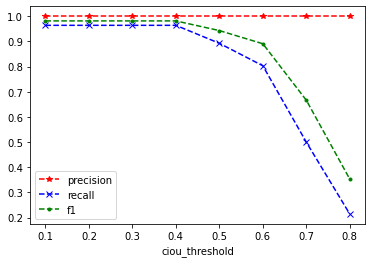

In [25]:
x  = ciou_thresholds
y1_union = precisions
y2_union = recalls
y3_union = f1s

plt.plot(x, y1_union, 'r--*')
plt.xlabel('ciou_threshold')   
# plt.ylabel('accuracy')  
plt.plot(x, y2_union, 'b--x')     
plt.plot(x, y3_union, 'g--.')     
plt.legend(['precision','recall','f1'])
plt.show()

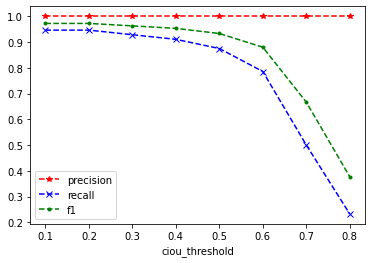

In [27]:
x  = ciou_thresholds
y1_big = precisions
y2_big = recalls
y3_big = f1s

plt.plot(x, y1_big, 'r--*')
plt.xlabel('ciou_threshold')   
# plt.ylabel('accuracy')  
plt.plot(x, y2_big, 'b--x')     
plt.plot(x, y3_big, 'g--.')     
plt.legend(['precision','recall','f1'])
plt.show()

# big_box v.s Union_box

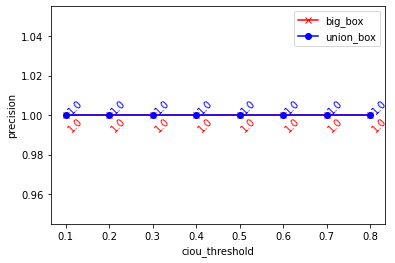

In [28]:
x  = ciou_thresholds

plt.plot(x, y1_big, 'r-x')  
plt.plot(x, y1_union, 'b-o') 

plt.xlabel('ciou_threshold') 
plt.ylabel('precision')  
plt.legend(['big_box','union_box'])

pltText(x, y1_big,'big')
pltText(x, y1_union,'union')
plt.show()

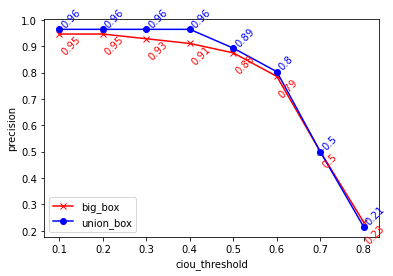

In [29]:
x  = ciou_thresholds

plt.plot(x, y2_big, 'r-x')  
plt.plot(x, y2_union, 'b-o') 

plt.xlabel('ciou_threshold') 
plt.ylabel('precision')  
plt.legend(['big_box','union_box'],loc='lower left')

pltText(x, y2_big,'big')
pltText(x, y2_union,'union')
plt.show()

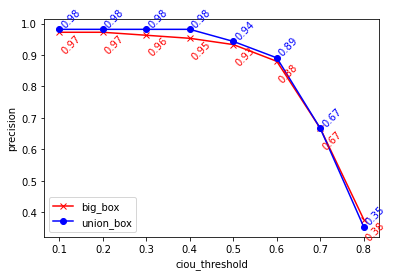

In [30]:
x  = ciou_thresholds

plt.plot(x, y3_big, 'r-x')  
plt.plot(x, y3_union, 'b-o') 

plt.xlabel('ciou_threshold') 
plt.ylabel('precision')  
plt.legend(['big_box','union_box'], loc='lower left')

pltText(x, y3_big,'big')
pltText(x, y3_union,'union')
plt.show()